In [2]:
from perfetto.trace_processor import TraceProcessor, TraceProcessorConfig
import matplotlib.pyplot as plt


In [543]:
config = TraceProcessorConfig(verbose=True,bin_path='./trace_processor')

tp = TraceProcessor(trace='./pixel/trace-mindar-aframe-camera-4-8',config=config)
qr_it = tp.query('select ts, counter_track.name, value  from counter left join counter_track where counter_track.id=counter.track_id')
qr_df = qr_it.as_pandas_dataframe()
print(qr_df.head())

[516.120]             httpd.cc:99 [HTTP] Starting RPC server on localhost:55662
[516.120]            httpd.cc:104 [HTTP] This server can be used by reloading https://ui.perfetto.dev and clicking on YES on the "Trace Processor native acceleration" dialog or through the Python API (see https://perfetto.dev/docs/analysis/trace-processor#python-api).


                 ts               name           value
0  2184153670805071    batt.charge_uah       4556000.0
1  2184153670805071  batt.capacity_pct           100.0
2  2184153670805071    batt.current_ua          -625.0
3  2184153672000000    power.rails.tpu    7891484665.0
4  2184153672000000  power.rails.modem  158666133066.0


[517.056]       http_server.cc:83 [HTTP] New connection
[517.056]      http_server.cc:231 [HTTP] GET /status [body=0B, origin=""]
[517.056]       http_server.cc:90 [HTTP] Client disconnected
[517.060]       http_server.cc:83 [HTTP] New connection
[517.060]      http_server.cc:231 [HTTP] POST /parse [body=105794B, origin=""]
[517.064]      http_server.cc:231 [HTTP] GET /notify_eof [body=0B, origin=""]
Loading trace 0.11 MB (0.0 MB/s)
[517.073]      http_server.cc:231 [HTTP] POST /query [body=116B, origin=""]


In [550]:
power_df = qr_df[qr_df['name'].str[:5] == 'power']
power_df = power_df.drop_duplicates()
print(power_df['ts'].value_counts())

ts
2184153672000000    8
2184153673000000    8
2184194728000000    8
2184194476000000    8
2184194475000000    8
                   ..
2184172976000000    8
2184172975000000    8
2184172730000000    8
2184172729000000    8
2184213477000000    8
Name: count, Length: 480, dtype: int64


['power.rails.aoc.logic', 'power.rails.aoc.memory', 'power.rails.cpu.big', 'power.rails.cpu.little', 'power.rails.cpu.mid', 'power.rails.ddr.a', 'power.rails.ddr.b', 'power.rails.ddr.c', 'power.rails.display', 'power.rails.gpu', 'power.rails.memory.interface', 'power.rails.modem', 'power.rails.radio.frontend', 'power.rails.system.fabric', 'power.rails.tpu', 'power.rails.wifi.bt']


/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1054655158.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] = diffs / time_diffs * 1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1054655158.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] = diffs / time_diffs * 1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/1054655158.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

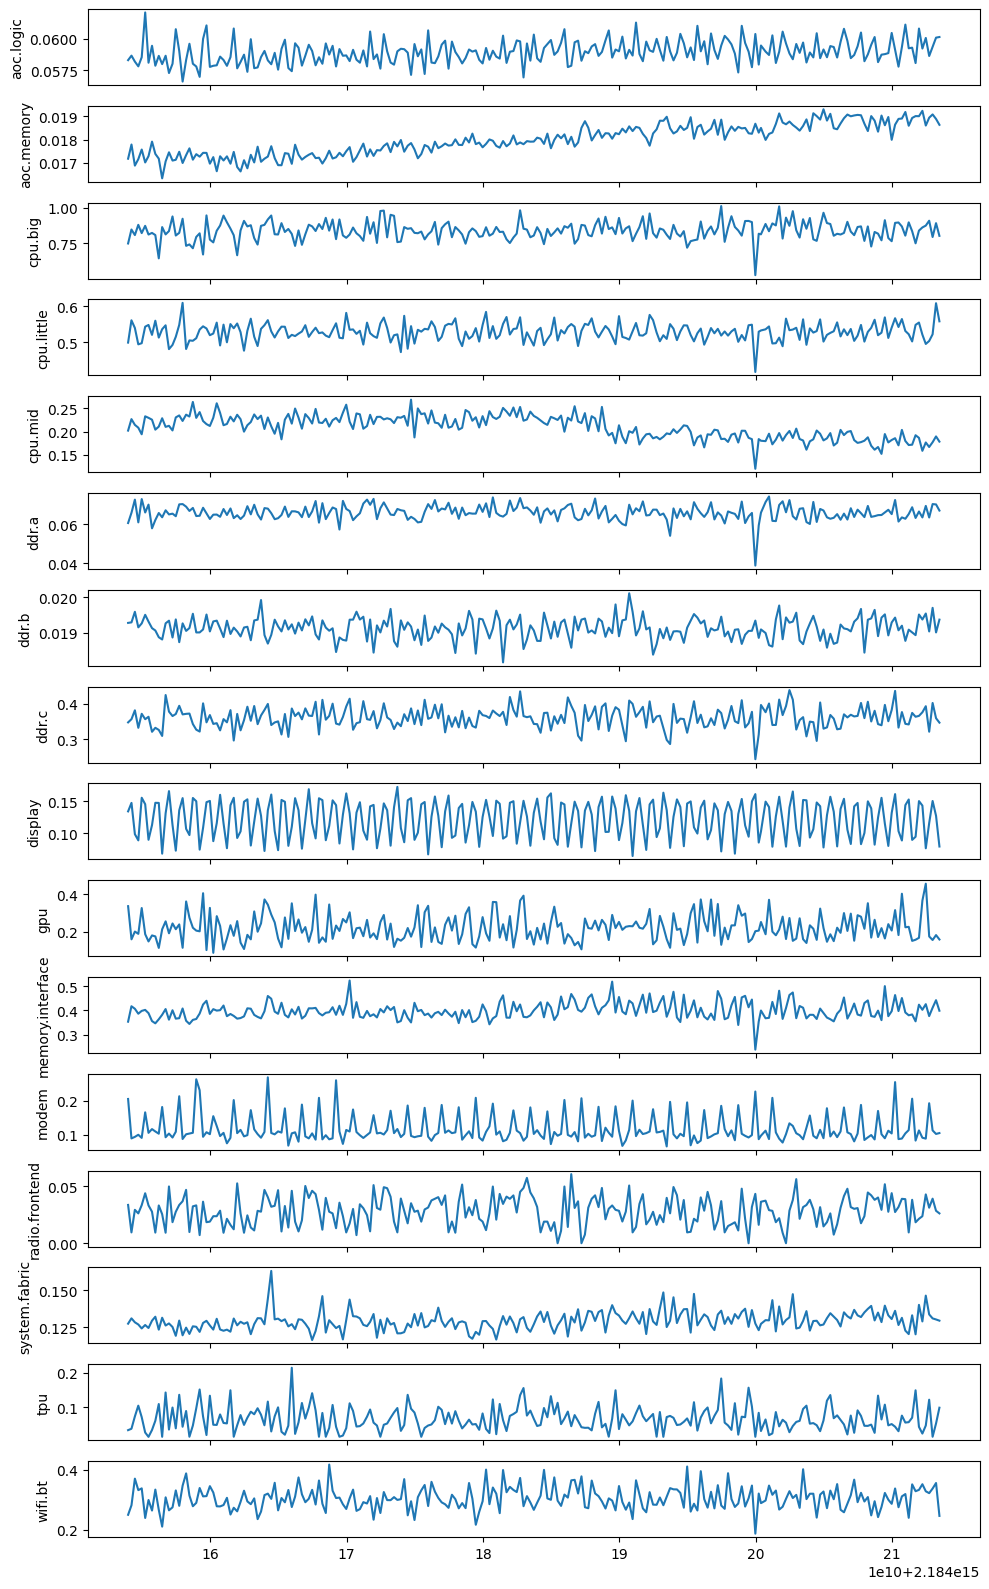

In [555]:


unique_names = sorted(power_df['name'].unique())
print(unique_names)

num_rows = len(unique_names)
num_cols = 1


fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 1*num_rows), sharex=True)

for i, name in enumerate(unique_names):
    data = power_df[power_df['name'] == name]
    diffs = data['value'].diff()
    time_diffs = data['ts'].diff()
    data['ratio'] = diffs / time_diffs * 1000
   
    axes[i].plot(data['ts'], data['ratio'],label=name)
    axes[i].set_ylabel(name[12:])



plt.tight_layout()

plt.show()


In [556]:
total_mean_ratio = 0
name_mean_ratio = {}
for i, name in enumerate(unique_names):
    data = power_df[power_df['name'] == name]
    diffs = data['value'].diff()
    time_diffs = data['ts'].diff()
    time_diffs_nonzero = time_diffs.replace(0, float('nan'))
    data['ratio'] =  diffs / time_diffs_nonzero*1000
    data_cleaned = data.dropna(subset=['ratio'])
    mean_ratio = data_cleaned['ratio'].mean()
    name_mean_ratio[name] = mean_ratio
    total_mean_ratio += mean_ratio

print("sum:", total_mean_ratio)
for name, mean_ratio in name_mean_ratio.items():
    ratio_percentage = (mean_ratio / total_mean_ratio) * 100
    print(f"{name} :{mean_ratio}, {ratio_percentage:.2f}%")


sum: 3.4905666194604663
power.rails.aoc.logic :0.05894011209866202, 1.69%
power.rails.aoc.memory :0.017989887496644708, 0.52%
power.rails.cpu.big :0.8386156438585786, 24.03%
power.rails.cpu.little :0.5289146506065955, 15.15%
power.rails.cpu.mid :0.2094398955094561, 6.00%
power.rails.ddr.a :0.06605841509852038, 1.89%
power.rails.ddr.b :0.019126310062885878, 0.55%
power.rails.ddr.c :0.3605913092300331, 10.33%
power.rails.display :0.12231775337733114, 3.50%
power.rails.gpu :0.22148937684971312, 6.35%
power.rails.memory.interface :0.39897583983358437, 11.43%
power.rails.modem :0.11758346932043409, 3.37%
power.rails.radio.frontend :0.0284426585030556, 0.81%
power.rails.system.fabric :0.12922910526520642, 3.70%
power.rails.tpu :0.06759642531794811, 1.94%
power.rails.wifi.bt :0.30525576703181706, 8.75%


/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/567107941.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] =  diffs / time_diffs_nonzero*1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/567107941.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] =  diffs / time_diffs_nonzero*1000
/var/folders/xk/5bd8h9y930n1m1vlv1v2r_wc0000gn/T/ipykernel_33812/567107941.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 